In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
train_dir = 'Dataset/Train'
val_dir = 'Dataset/Validate'
test_dir = 'Dataset/Test'

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescale Validation and Test Data
val_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # Binary classification: Helmet vs Non-Helmet
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 561 images belonging to 2 classes.
Found 164 images belonging to 2 classes.
Found 85 images belonging to 2 classes.


In [ ]:
# Load MobileNetV2 without the top classification layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Flatten the output features
model = Model(inputs=base_model.input, outputs=base_model.output)

# Function to extract features for an entire dataset
def extract_features(generator, model):
    features = []
    labels = []
    for batch_images, batch_labels in generator:
        # Pass images through MobileNetV2 to get features
        batch_features = model.predict(batch_images)
        # Flatten features (Global Average Pooling can also be applied here)
        batch_features = batch_features.reshape(batch_features.shape[0], -1)
        features.append(batch_features)
        labels.append(batch_labels)
        # Break when the generator is exhausted
        if generator.batch_index == 0:  # Reset occurs when epoch is complete
            break
    return np.vstack(features), np.hstack(labels)

train_features, train_labels = extract_features(train_generator, model)
val_features, val_labels = extract_features(val_generator, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


In [4]:
# Create a pipeline with feature scaling and SVM
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))

# Train the SVM
svm_model.fit(train_features, train_labels)

# Evaluate on validation data
val_accuracy = svm_model.score(val_features, val_labels)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Validation Accuracy: 80.49%


In [5]:
# Predict on new images
test_features, test_labels = extract_features(test_generator, model)
predictions = svm_model.predict(test_features)

# Evaluate on test data
test_accuracy = svm_model.score(test_features, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Test Accuracy: 81.18%



Classification Report:
              precision    recall  f1-score   support

      Helmet       0.83      0.79      0.81        43
  Non-Helmet       0.80      0.83      0.81        42

    accuracy                           0.81        85
   macro avg       0.81      0.81      0.81        85
weighted avg       0.81      0.81      0.81        85



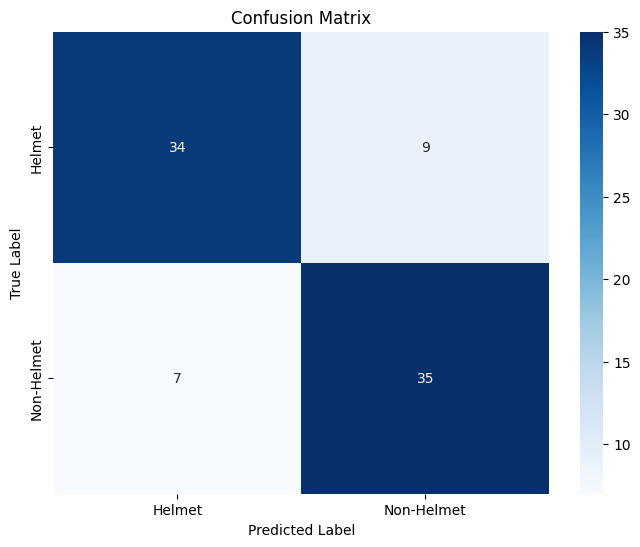

In [16]:
print("\nClassification Report:")
print(classification_report(test_labels, predictions, target_names=['Helmet', 'Non-Helmet']))

cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Helmet', 'Non-Helmet'], 
            yticklabels=['Helmet', 'Non-Helmet'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Predicted Class: Non-Helmet, Confidence: 82.14%


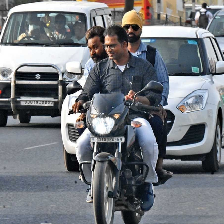

In [15]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load a random image from your computer
image_path = "nh4.jpg"  # Replace with the path to your image
image = load_img(image_path, target_size=(224, 224))  # Resize to 224x224
image_array = img_to_array(image)  # Convert to NumPy array
image_array = image_array / 255.0  # Normalize pixel values (0-255 → 0-1)

# Add batch dimension (MobileNetV2 expects a 4D input: [batch_size, height, width, channels])
image_array = np.expand_dims(image_array, axis=0)

# Extract features using MobileNetV2
features = model.predict(image_array)

# Flatten the feature map to a 1D vector
features = features.reshape(1, -1)  # Reshape to match SVM's input format

# Predict using the trained SVM model
prediction = svm_model.predict(features)
probabilities = svm_model.predict_proba(features)

# Output the result
class_labels = train_generator.class_indices  # Mapping of class labels (e.g., {'Helmet': 0, 'Non-Helmet': 1})
class_labels = {v: k for k, v in class_labels.items()}  # Reverse mapping (e.g., {0: 'Helmet', 1: 'Non-Helmet'})

# Ensure prediction is an integer
predicted_index = int(prediction[0])  # Extract the class index
confidence = probabilities[0][predicted_index] * 100
# Reverse mapping of class labels (e.g., {0: 'Helmet', 1: 'Non-Helmet'})
class_labels = {v: k for k, v in train_generator.class_indices.items()}

# Ensure prediction index is correct
predicted_index = int(prediction[0])  # Extract the predicted class index
predicted_class = class_labels[predicted_index]  # Map to class name

# Get confidence for the predicted class
confidence = probabilities[0][predicted_index] * 100

print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")

image

